In [210]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt 
from utils import random_psd
from geometric_optimizers import RGD_optimizer, RAGD_optimizer, RAGDsDR_optimizer
from pymanopt.manifolds import Sphere
import torch
import time
%config InlineBackend.figure_format = 'svg'

In [211]:
d = 2000
n = int(1.05*d)
seed = 159
np.random.seed(seed)
A = np.random.randn(d,n)/np.sqrt(n)
H = np.dot(A,A.T)

#H=random_psd(d,10000,23)

#Manifold functions
M = Sphere(d)
def cost(X):return -0.5*np.dot(X,np.dot(H, X))
def egrad(X):return -np.dot(H,X)
def grad(X):return M.egrad2rgrad(X,egrad(X))
def retr(X):return M.retr(X,0*X)
def exp(X,U):return M.exp(X,U)
def rexp(X,U):return retr(M.exp(X,U))
def log(X,Y):return M.log(X,Y)
def dist(X,Y):return M.dist(X,Y)
def transp(X,Y,U):return M.transp(X,Y,U)


eigenvalues, eigenvectors = la.eig(H)
max_eig = np.max(eigenvalues)
min_eig = np.min(eigenvalues)
x_sol = retr(eigenvectors[:, np.argmax(eigenvalues)])


# iterations to solve
N = 1000
line_search_iterations = 100
mu = min_eig
L = max_eig
h = 1/L

print(mu)
print(L)

#starting position
np.random.seed(seed)
x0=retr(10*np.random.randn(d,))
h

0.000545622091030506
3.867412827776622


0.25857079255097276

In [212]:
t1,f1 = RGD_optimizer(N,x0,h,cost,grad,exp)
t2,f2 = RAGDsDR_optimizer(N,x0,h,cost,grad,rexp,log,transp,line_search_iterations)
t3,f3 = RAGD_optimizer(N,x0,h,mu,cost,grad,exp,log)
t4,f4 = RAGDsDR_optimizer(N,x0,h,cost,grad,rexp,log,transp,-1)

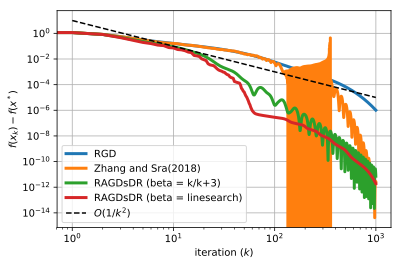

In [213]:
fig, ax = plt.subplots()
ax.loglog(range(N), f1-cost(x_sol),label='RGD',linewidth=3)
ax.loglog(range(N), f3-cost(x_sol),label='Zhang and Sra(2018)',linewidth=3)
ax.loglog(range(N), f4-cost(x_sol),label='RAGDsDR (beta = k/k+3)',linewidth=3)
ax.loglog(range(N), f2-cost(x_sol),label='RAGDsDR (beta = linesearch)',linewidth=3)
#ax.loglog(range(N), 10*np.divide(1,range(N)),'--',label='$O(1/k)$',color='black')
ax.loglog(range(N), 10*np.divide(1,np.power(range(N),2)),'--',label='$O(1/k^2)$',color='black')
ax.set(xlabel='iteration $(k)$', ylabel='$f(x_k)-f(x^*)$')

ax.grid()
ax.legend()
#ax.set_ylim(bottom=1e-15)
plt.show()
#fig.savefig('OK1.eps', format='eps', dpi=1000)

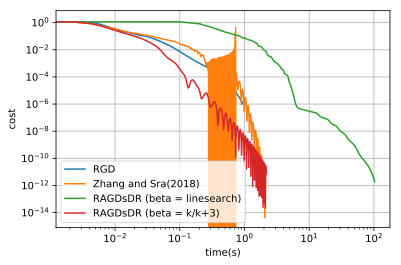

In [214]:
fig, ax = plt.subplots()
ax.loglog(t1, f1-cost(x_sol),label='RGD')
ax.loglog(t3, f3-cost(x_sol),label='Zhang and Sra(2018)')
ax.loglog(t2, f2-cost(x_sol),label='RAGDsDR (beta = linesearch)')
ax.loglog(t4, f4-cost(x_sol),label='RAGDsDR (beta = k/k+3)')
ax.set(xlabel='time(s)', ylabel='cost')
ax.grid()
ax.legend()
#ax.set_ylim(bottom=1e-15)
plt.show()
#fig.savefig('ex0.eps', format='eps', dpi=1000)